# MRC - Deep learning showcase

Content:
1. Working with image data in R (downloading data, plotting, preprocessing)
2. Creating deep learning architectures using the keras interface
    1. Starting with Fashion MNIST
    2. Evaluation of model output
    3. Storage and loading of models
    4. Sequential and Functional API
3. Running and comparing different architectures (FCN, CNN)
4. Regularization and its effects on the generalization performance
5. Transfer learning with pretrained models in case of few labeled data
6. Data generator functionality for huge data sets


## 1. Working with image data in R

### Data provided by the keras package - MNIST

MNIST is a [famous dataset provided by Yann LeCun et al.](http://yann.lecun.com/exdb/mnist/) that consists of 70K 28x28 grayscale images of handwritten digits.

In [11]:
# install and load requried packages
# use install.packages('<package name>') to install a packages
# use library('<package name>') to load already installed packages
# devtools::install_github('rstudio/keras')
library('keras')
library('grid')
library('magick')

Warning message:
“package ‘magick’ was built under R version 3.4.4”Linking to ImageMagick 6.9.9.39
Enabled features: cairo, fontconfig, freetype, lcms, pango, rsvg, webp
Disabled features: fftw, ghostscript, x11


In [12]:
# files will be stored at
# ~/.keras/datasets
mnist = dataset_mnist()
# what does the object contain?
str(mnist)
# 60K train and 10K test data with input X and labels y

List of 2
 $ train:List of 2
  ..$ x: int [1:60000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:60000(1d)] 5 0 4 1 9 2 1 3 1 4 ...
 $ test :List of 2
  ..$ x: int [1:10000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:10000(1d)] 7 2 1 0 4 1 4 9 5 9 ...


In [4]:
# assign values 
x_train = mnist$train$x
x_test = mnist$test$x
y_train = mnist$train$y
y_test = mnist$test$y

In [5]:
# classes for train and test are equally balanced 
# (-> what if they were not?)
table(y_test)
table(y_train)

y_test
   0    1    2    3    4    5    6    7    8    9 
 980 1135 1032 1010  982  892  958 1028  974 1009 

y_train
   0    1    2    3    4    5    6    7    8    9 
5923 6742 5958 6131 5842 5421 5918 6265 5851 5949 

In [6]:
# x_train is an array that contains 60K images with channel size 1 and dimensions 28x28 (as they are black-white)
# resulting in tensor of shape [amount images, xdim, ydim]
# If the images were coloured, they would contain  3 channels (RGB) resulting in shape
# [60000, 28, 28, 3]

# inspect one train image
idx = 87
foo_img = x_train[idx, , ]
foo_label = y_train[idx]
cat(paste0('class: ', class(foo_img), 
    '\nmax value: ', max(foo_img), 
    '\nmin value: ', min(foo_img), 
    '\nmean value: ', mean(foo_img),
    '\ndata type: ', typeof(foo_img)))

class: matrix
max value: 254
min value: 0
mean value: 27.8469387755102
data type: integer

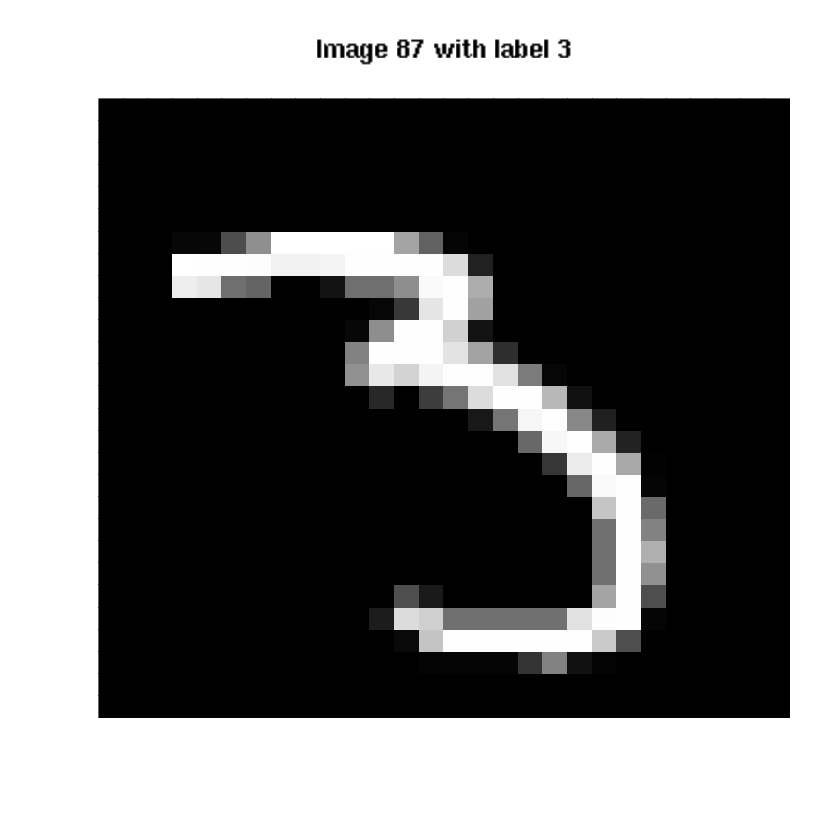

In [54]:
# helper to rotate the image
rot = function(x){t(apply(x, 2, rev))}
# plot the image with the label as header
image(rot(foo_img), 
    axes = FALSE, 
    col = grey(seq(0, 1, length = 256)), 
    main = paste0('Image ', idx, ' with label ', foo_label))

### Data provided by the keras package - Fashion MNIST

Fashion Mnist is mainly a more complicated version of MNIST with 10 classes of different fashion objects. The dataset is published by [Zalando Research](https://github.com/zalandoresearch/fashion-mnist) and also often used for deep learning benchmarks. The dataset as well consists of 70K 28x28 grayscale images of fashion objects in 10 balanced categories such as bags, shoes, trousers, ...

In [7]:
# files will be stored at
# ~/.keras/datasets
fmnist = dataset_fashion_mnist()
# what does the object contain?
str(fmnist)
# 60K train and 10K test data with input X and labels y
# assign values 
x_train = fmnist$train$x
x_test = fmnist$test$x
y_train = fmnist$train$y
y_test = fmnist$test$y

List of 2
 $ train:List of 2
  ..$ x: int [1:60000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:60000(1d)] 9 0 0 3 0 2 7 2 5 5 ...
 $ test :List of 2
  ..$ x: int [1:10000, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ y: int [1:10000(1d)] 9 2 1 1 6 1 4 6 5 7 ...


class: matrix
max value: 255
min value: 0
mean value: 107.353316326531
data type: integer

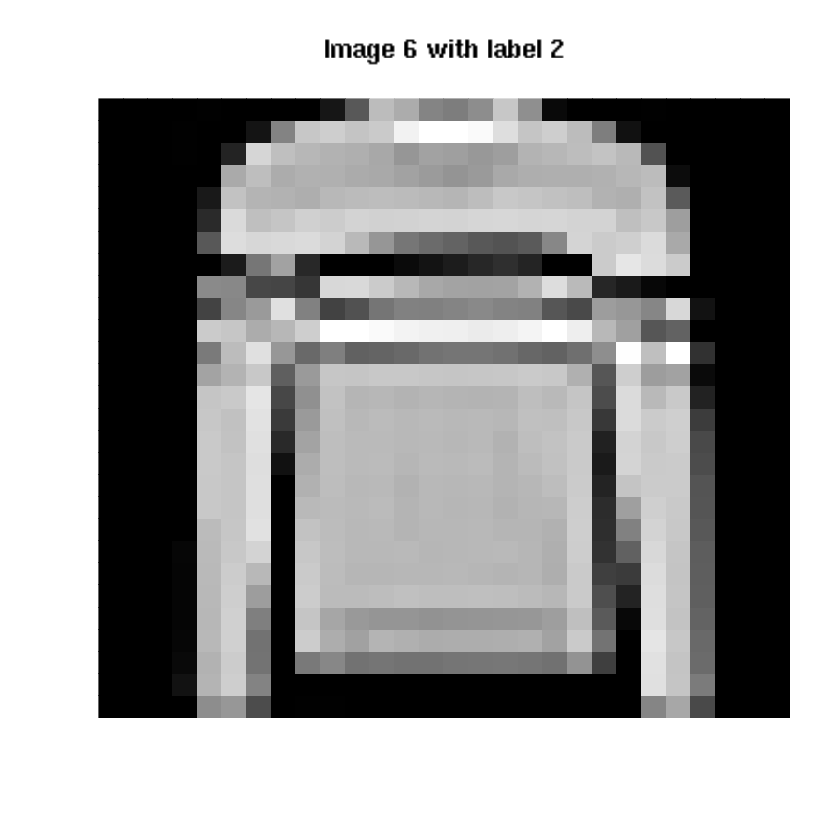

In [8]:
# inspect one train image
idx = 6
foo_img = x_train[idx, , ]
foo_label = y_train[idx]
cat(paste0('class: ', class(foo_img), 
    '\nmax value: ', max(foo_img), 
    '\nmin value: ', min(foo_img), 
    '\nmean value: ', mean(foo_img),
    '\ndata type: ', typeof(foo_img)))
# helper to rotate the image
rot = function(x){t(apply(x, 2, rev))}
# plot the image with the label as header
image(rot(foo_img), 
    axes = FALSE, 
    col = grey(seq(0, 1, length = 256)), 
    main = paste0('Image ', idx, ' with label ', foo_label))

### Data provided by the keras package - CIFAR 10

Cifar10 is a [public dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html) that contains 60K 32x32 RGB images from 10 classes (airplanes, deer, cars, cats, ...) and is widely used for benchmarking DL algorithms in image classification. 

In [11]:
# can take up to 5 min as the dataset contains roughly 170MB
# also stored at ~/.keras/datasets
cifar = dataset_cifar10()

In [12]:
# similar structure as MNIST
# but now with channel depth 3
str(cifar)
x_train = cifar$train$x
y_train = cifar$train$y
x_test = cifar$test$x
y_test = cifar$test$y

List of 2
 $ train:List of 2
  ..$ x: int [1:50000, 1:32, 1:32, 1:3] 59 154 255 28 170 159 164 28 134 125 ...
  ..$ y: int [1:50000, 1] 6 9 9 4 1 1 2 7 8 3 ...
 $ test :List of 2
  ..$ x: int [1:10000, 1:32, 1:32, 1:3] 158 235 158 155 65 179 160 83 23 217 ...
  ..$ y: num [1:10000, 1] 3 8 8 0 6 6 1 6 3 1 ...


class: array
max value: 247
min value: 0
mean value: 111.307291666667
data type: integer
label of image 177 is 1

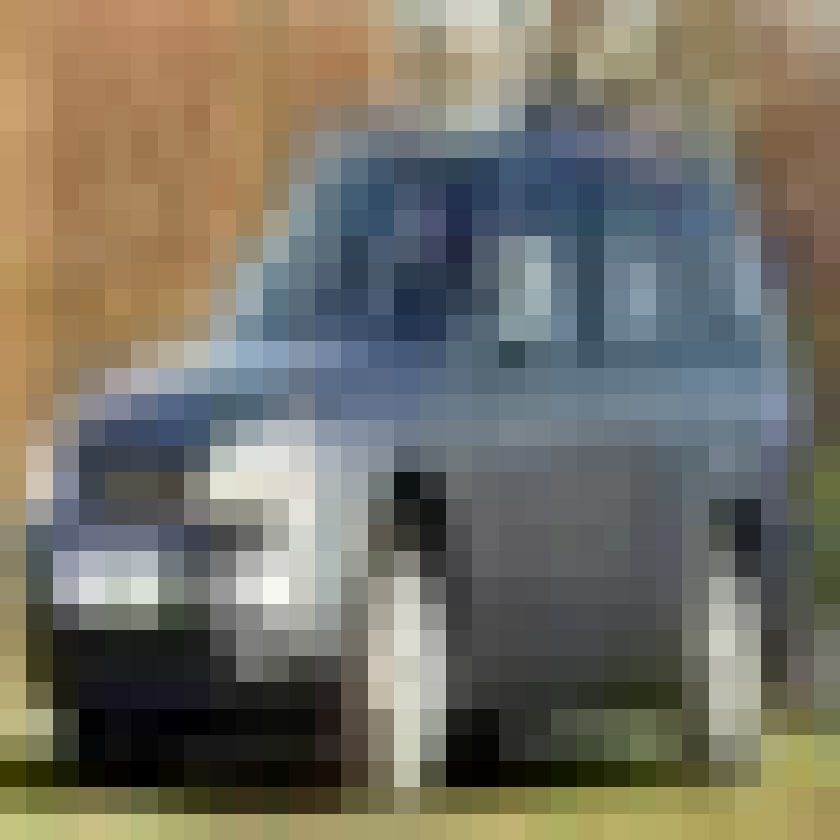

In [13]:
# inspect one train image
# consists of 3 matrices of RGB integers in {0, ..., 255}
idx = 177
foo_img = x_train[idx, , ,]
foo_label = y_train[idx]
cat(paste0('class: ', class(foo_img), 
    '\nmax value: ', max(foo_img), 
    '\nmin value: ', min(foo_img), 
    '\nmean value: ', mean(foo_img),
    '\ndata type: ', typeof(foo_img)))

# print the label 
cat(paste0('\nlabel of image ', idx, ' is ', foo_label))

# plot the images with grid package
# therefore, pixels have to be squashed to [0, 1]
r = foo_img[ , , 1] / 255
g = foo_img[ , , 2] / 255
b = foo_img[ , , 3] / 255
col <- rgb(r, g, b)
dim(col) <- dim(r)
grid.raster(col, interpolate=FALSE, name = "yo")

## Load and manipulate your own image data

We transform one example image in the R-eadable data format. [Random Forest creator Leo Breiman](https://de.wikipedia.org/wiki/Leo_Breiman) serves as an example here. The R package [magick](https://cran.r-project.org/web/packages/magick/vignettes/intro.html#installing_magick) offers very comprehensive image manipulation methods in a unified framework.

In [14]:
# install.packages('magick')
# read the image
data_path = './data/Breiman.jpg'
img = image_read(path = data_path)


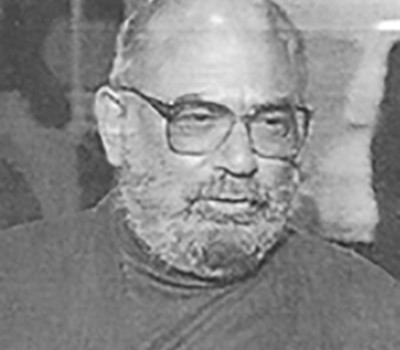

  format width height colorspace matte filesize density
1   JPEG   400    350       Gray FALSE    23266   72x72

In [15]:
# plot the image
img

In [16]:
# get data from the image object
# then convert it to integer values
img_data = as.integer(image_data(img))
# dimension of the image
dim(img_data)
# some elements of the image
img_data[25:30, 40:45, 1]
# values should lie in the range {0, ..., 255}
summary(img_data)

[1] 350 400   1

81,81,81,81,80,78
82,82,83,83,82,80
83,83,84,85,84,82
82,82,83,85,85,83
79,79,81,83,83,83
76,76,78,80,81,80


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   30.0   109.0   123.0   136.3   171.0   255.0 

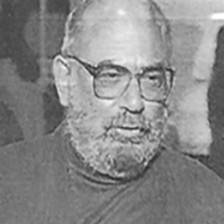

  format width height colorspace matte filesize density
1   JPEG   224    224       Gray FALSE        0   72x72

In [17]:
# resize the image in case they have different formats
# e.g. Resnet takes 224x224 images as input
resized_img = magick::image_resize(image = img, geometry = "224x224!")
resized_img

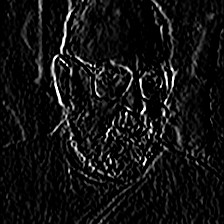

  format width height colorspace matte filesize density
1   JPEG   224    224       Gray FALSE        0   72x72

In [18]:
# Convolve over the image with a Sobel filter to detect edges (as is done in the lecture slides)
# therefore, the pipe operator is used which works the same was as in unix
sobel_img = resized_img %>%
    image_convolve('Sobel')
sobel_img

## 2. Getting started with Keras for modeling

Running and training neural networks with keras mainly consists of the following steps:
1. Reading and splitting data
2. Defininig the architecture of the model
3. Training the model and setting the hyperparameters for this
4. Evaluation of the model performance
5. Introduction to the functional API

In the following, we will train different model architectures on the task to classifiy the Fashion Mnist images in their corresponding 10 categories. Also, Keras allows the specification of the model architecture in a *sequential* and a *functional* way, both of which will be used in the following. 


### 2.1 Reading and preparing the data

In [20]:
# read the data
fmnist = dataset_fashion_mnist()
# assign values 
x_train = fmnist$train$x
x_test = fmnist$test$x
y_train = fmnist$train$y
y_test = fmnist$test$y
# dictionary for translation of the labels to meaningful category names
label_dict = cbind(c('tshirt', 'trouser', 'pullover', 'dress', 'coat', 
                     'sandal', 'shirt', 'sneaker', 'bag', 'ankleboot'), 
                   c(0:9))

In [21]:
dim(x_train)

[1] 60000    28    28

In [22]:
# convert the labels to categorical one-hot-encoded vectors
# store the real value as well and translate them into meaningful classes
y_train_noncateg = cbind(y_train, label_dict[match(y_train, label_dict[, 2]), 1])
y_test_noncateg = cbind(y_test, label_dict[match(y_test, label_dict[, 2]), 1])
y_train = to_categorical(y = y_train)
y_test = to_categorical(y = y_test)

# flatten the data input arrays from 60K 28x28 matrix to 60K 784 vector format
x_train = array_reshape(x_train, c(nrow(x_train), 28*28))
x_test = array_reshape(x_test, c(nrow(x_test), 28*28))

### 2.2 Defining the architecture - Sequential

For a first run, we want to use a Multi-Layer-Preceptron (MLP), which consists of three inner hidden layers with varying size (128, 64, 32). In this example, we use the __sequential architecture__ which allows to stack layers upon each other using the __pipe operator %>%__ which is known from the unix bash. 


In [23]:
# define and instantiate the sequential model type
model_seq = keras_model_sequential() 

# build the model sequentially layer-wise with the pipe operator %>%
model_seq %>% 
    # input the data as vectors of length 28x28 = 784
    # define the three hidden layers with relu activation and (128, 64, 32) neurons per layer
    layer_dense(units = 128, activation = 'relu', input_shape = c(784)) %>% 
    layer_dense(units = 64, activation = 'relu') %>%
    layer_dense(units = 32, activation = 'relu') %>%

    # add softmax as activation for the last layer as we want to output probality 
    # scores in [0, 1] for the 10 classes
    layer_dense(units = 10, activation = 'softmax')


In [24]:
# summary() allows us to check the architecture
# for instance, the 3rd layer contains 2080 = 64*32 + 32 weight parameters, as 32 neurons are connected
# with the output from the preceeding 64 neurons and are each combined with a bias factor
summary(model_seq)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 128)                     100480      
________________________________________________________________________________
dense_2 (Dense)                     (None, 64)                      8256        
________________________________________________________________________________
dense_3 (Dense)                     (None, 32)                      2080        
________________________________________________________________________________
dense_4 (Dense)                     (None, 10)                      330         
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
________________________________________________________________________________


### 2.3 Compiling and running the model 

In [25]:
# again, use the pipe operator %>%
# choose categorical cross entropy as the classifier loss and 
# optimize the weights sequentially with rmsprop 
# check the CRAN documentation for more information on choosable losses, optimizer and metrics
# this step defines the computational graph that is getting executed in the next step
model_seq %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

In [26]:
# train the compiled model with the fit function
# save the training progress in the history file
history = model_seq %>% fit(
    x_train, y_train, 
    epochs = 3, batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1
)

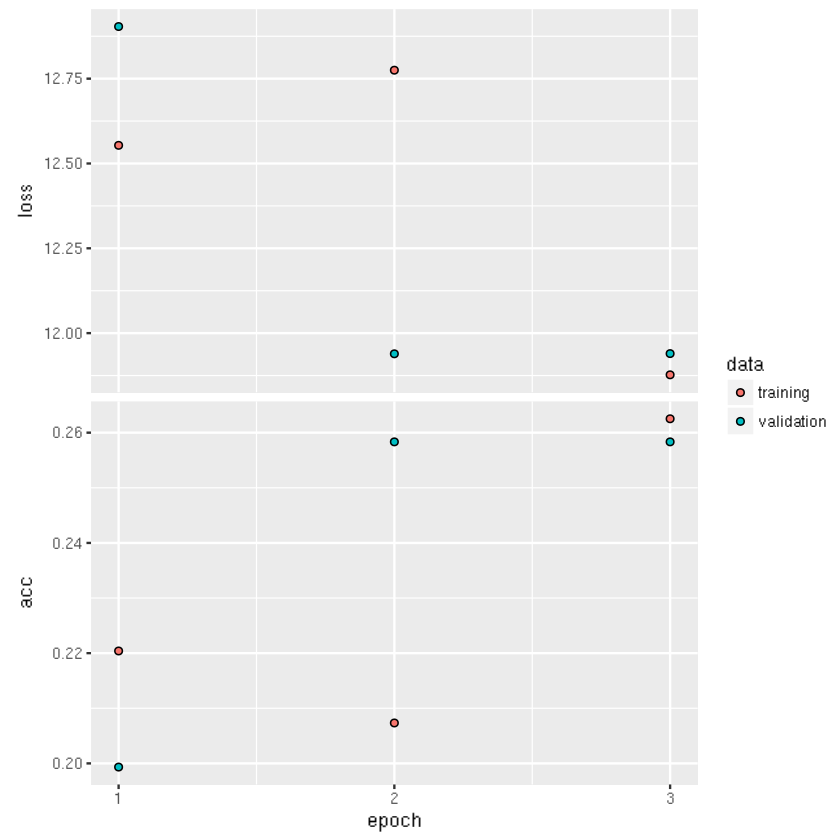

In [28]:
# inspect the train and validation history
plot(history)

### 2.4 Making predictions and performance evaluation

In [78]:
# get the test performance of the trained model
test_perf = model_seq %>% evaluate(x_test, y_test)
test_perf

$loss
[1] 11.88897

$acc
[1] 0.2614

In [69]:
# make hard predictions on all our test data
preds = model_seq %>% predict_classes(x_test)
pred_frame = as.data.frame(cbind(preds, label_dict[match(preds, label_dict[, 2]), 1], y_test_noncateg))
pred_frame[, 1] = factor(pred_frame[, 1], levels = as.character(c(0:9)))
colnames(pred_frame) = c('yhat', 'yhat_label', 'y', 'y_label')
head(pred_frame)

yhat,yhat_label,y,y_label
5,sandal,9,ankleboot
5,sandal,2,pullover
1,trouser,1,trouser
1,trouser,1,trouser
5,sandal,6,shirt
1,trouser,1,trouser


In [70]:
# make soft predictions (softmax) on all our test data
preds = model_seq %>% predict_proba(x_test)
soft_pred_frame = cbind(preds, y_test_noncateg)
colnames(soft_pred_frame) = c(paste0('yhat_class_', c(0:9)), 'y', 'y_label')
head(soft_pred_frame)

yhat_class_0,yhat_class_1,yhat_class_2,yhat_class_3,yhat_class_4,yhat_class_5,yhat_class_6,yhat_class_7,yhat_class_8,yhat_class_9,y,y_label
0,0,0,0,0,1,0,0,0,0,9,ankleboot
0,0,0,0,0,1,0,0,0,0,2,pullover
0,1,0,0,0,0,0,0,0,0,1,trouser
0,1,0,0,0,0,0,0,0,0,1,trouser
0,0,0,0,0,1,0,0,0,0,6,shirt
0,1,0,0,0,0,0,0,0,0,1,trouser


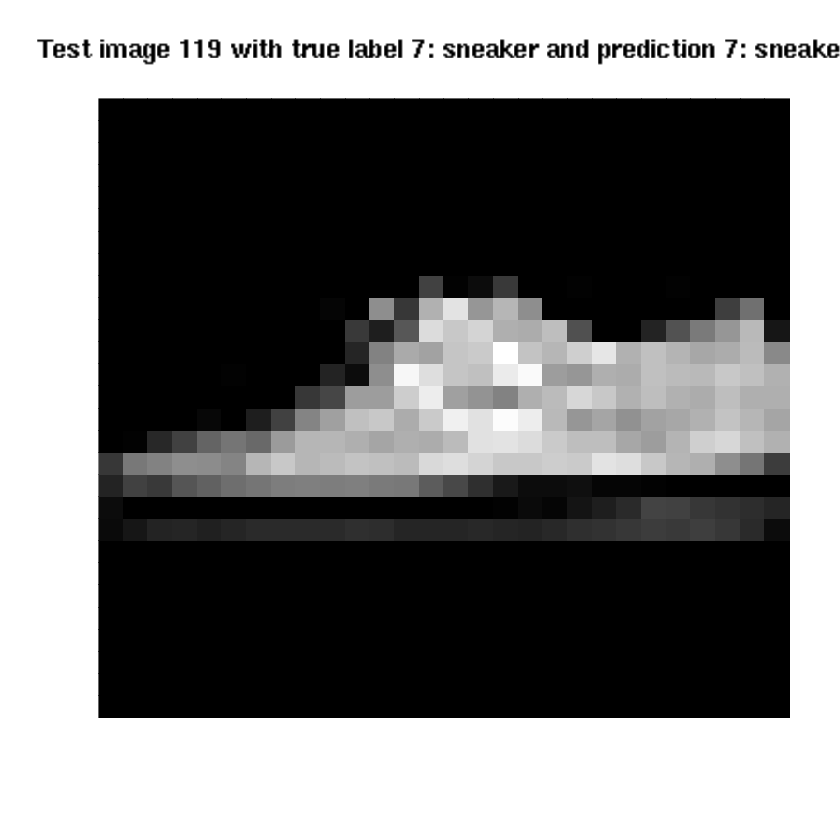

In [57]:
# check predictions for one test image
idx = 119
img_test = array_reshape(x_test[idx, ], c(28, 28))
rot = function(x){t(apply(x, 2, rev))}
# plot the image with the label as header
image(rot(img_test), 
    axes = FALSE, 
    col = grey(seq(0, 1, length = 256)), 
    main = paste0('Test image ', idx,  
                ' with true label ', 
                y_test_noncateg[idx, 1], 
                ': ', 
                y_test_noncateg[idx, 2], 
                ' and prediction ', 
                pred_frame[idx, 1], ': ', 
                pred_frame[idx, 2]))

#### Confusion matrix

In [79]:
# instantiate empty confusion matrix as data frame
conf_frame = as.data.frame(matrix(0, nrow = 10, ncol = 10))
# transform factors to integers
pred_frame$y = as.integer(pred_frame$y)
pred_frame$yhat = as.integer(pred_frame$yhat)
# loop over all possible true labels
for(label in 1:10){
    # filter for current label
    dat = pred_frame %>% 
        dplyr::filter(y == label)
    # loop over all predictable labels
    for(pred in 1:10){
        # count for each predictable label, how often it was predicted for which lass
        conf_frame[pred, label] = length(which(dat[, 1] == pred)) 
    }
}
# rename the columns with the actual label values
colnames(conf_frame) = label_dict[, 1]
rownames(conf_frame) = label_dict[, 1]

In [80]:
# inspect the confusion matrix
# rows represent the predicted values and columns represent the true values
# a perfect confusion matrix contains only non-zero values on the diagonal 
# how can we interpret those results?
conf_frame

,tshirt,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,ankleboot
tshirt,0,0,0,0,0,0,0,0,0,0
trouser,911,987,432,969,496,0,541,0,17,0
pullover,0,0,0,0,0,0,0,0,0,0
dress,0,0,0,0,0,0,0,0,0,0
coat,0,0,0,0,0,0,0,0,0,0
sandal,89,13,568,31,504,984,459,357,981,936
shirt,0,0,0,0,0,0,0,0,0,0
sneaker,0,0,0,0,0,16,0,643,2,64
bag,0,0,0,0,0,0,0,0,0,0
ankleboot,0,0,0,0,0,0,0,0,0,0


#### Saving and re-loading the model weights

In [74]:
# save model weights and architecture to hdf5 file
save_model_hdf5(object =  model_seq, filepath = './model_1.h5')

In [76]:
# load model with a new name 
loaded_model = load_model_hdf5(filepath = './model_1.h5')
# check the architecture 
summary(loaded_model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 128)                     100480      
________________________________________________________________________________
dense_2 (Dense)                     (None, 64)                      8256        
________________________________________________________________________________
dense_3 (Dense)                     (None, 32)                      2080        
________________________________________________________________________________
dense_4 (Dense)                     (None, 10)                      330         
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
________________________________________________________________________________


In [81]:
# test performance of the loaded model on the same test data
loaded_model %>% evaluate(x_test, y_test)

$loss
[1] 11.88897

$acc
[1] 0.2614

### 2.5 Defining the architecture - Functional

Again, we want to use a Multi-Layer-Preceptron (MLP), which consists of three inner hidden layers with varying size (128, 64, 32). For this chapter, the functional style is used. 

In [82]:
# define the start point of the architecture (input layer)
input = layer_input(shape = c(784))

# define the end point of the computational graph (predictions)
output = input %>% 
    layer_dense(units = 128, activation = 'relu', input_shape = c(784)) %>% 
    layer_dense(units = 64, activation = 'relu') %>%
    layer_dense(units = 32, activation = 'relu') %>%
    layer_dense(units = 10, activation = 'softmax')

# merge both layers to compile the model
model_func = keras_model(inputs = input, outputs = output)
model_func %>% compile(
  optimizer = 'rmsprop',
  loss = 'categorical_crossentropy',
  metrics = c('accuracy')
)

# fit the model
history = model_func %>% fit(
    x = x_train, y = y_train, 
    epochs = 3, batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1
)

# check test performance
model_func %>% evaluate(x_test, y_test)

$loss
[1] 10.26613

$acc
[1] 0.3627

In [84]:
# compare both architectures
summary(model_seq)
summary(model_func)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 128)                     100480      
________________________________________________________________________________
dense_2 (Dense)                     (None, 64)                      8256        
________________________________________________________________________________
dense_3 (Dense)                     (None, 32)                      2080        
________________________________________________________________________________
dense_4 (Dense)                     (None, 10)                      330         
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
________________________________________________________________________________
________________________________________________________________________________
Layer (type)                        O

# 3. Different architectures: from FCN to CNN

In chapter two, each image was treated as a vector of integers of size 28x28=784 which was then fed in to a Multi-Layer-Perceptron, also called *Vanilla-Fully-Connected-Network*. 

An alternative to this simple neural net architecture is the use of __convolutional layers__ to extraxt features throughout the network. 

Convolutional neural networks (CNNs) are very popular in image processing tasks and recently are as well adapted to text and sequence modeling tasks. We apply them on the Fashion MNIST task and compare the performance with the previous FCN architecture. We will use the sequential modeling style for this task.

In [85]:
# define and instantiate the sequential model type
model_conv = keras_model_sequential() 

model_conv %>% 
    # input the data as matrices of dimension 28x28x1 as we are working with grayscale images
    # first convolutional block creating 64 feature maps
    layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = 'relu', 
                 padding = 'same', input_shape = c(28, 28, 1)) %>% 
    layer_max_pooling_2d(pool_size = c(3, 3)) %>% 

    # second convolutional block creating 128 feature maps
    layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = 'relu', 
                 padding = 'same') %>% 
    layer_max_pooling_2d(pool_size = c(3, 3)) %>% 

    # connect the feature maps with a fully connected (dense) layer to the final output
    # therefore, flatten the 2dimensional feature maps to vector format
    layer_flatten() %>% 
    layer_dense(units = 512, activation = 'relu') %>% 
    layer_dense(units = 10, activation = 'softmax')

# compile the model 
model_conv %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

# check the model architecture
summary(model_conv)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_1 (Conv2D)                   (None, 28, 28, 64)              640         
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 9, 9, 64)                0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 9, 9, 128)               73856       
________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)      (None, 3, 3, 128)               0           
________________________________________________________________________________
flatten_1 (Flatten)                 (None, 1152)                    0           
________________________________________________________________________________
dense_9 (Dense)             

In [86]:
# get the data in 28x28 format
fmnist = dataset_fashion_mnist()
x_train = fmnist$train$x
x_test = fmnist$test$x
y_train = fmnist$train$y
y_test = fmnist$test$y

# reshape the array to dimension (#data, Xdim, Ydim, #channels)
x_train = array(x_train, c(60000, 28, 28, 1))
x_test = array(x_test, c(10000, 28, 28, 1))

# check the dimensionality of each of the 60K train images
dim(x_train)
# one-hot encode the labels
y_train = to_categorical(y = y_train)
y_test = to_categorical(y = y_test)


[1] 60000    28    28     1

In [88]:
# train the compiled model with the fit function
# save the training progress in the history file
history = model_conv %>% fit(
    x = x_train, 
    y = y_train, 
    epochs = 2, 
    batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1
)

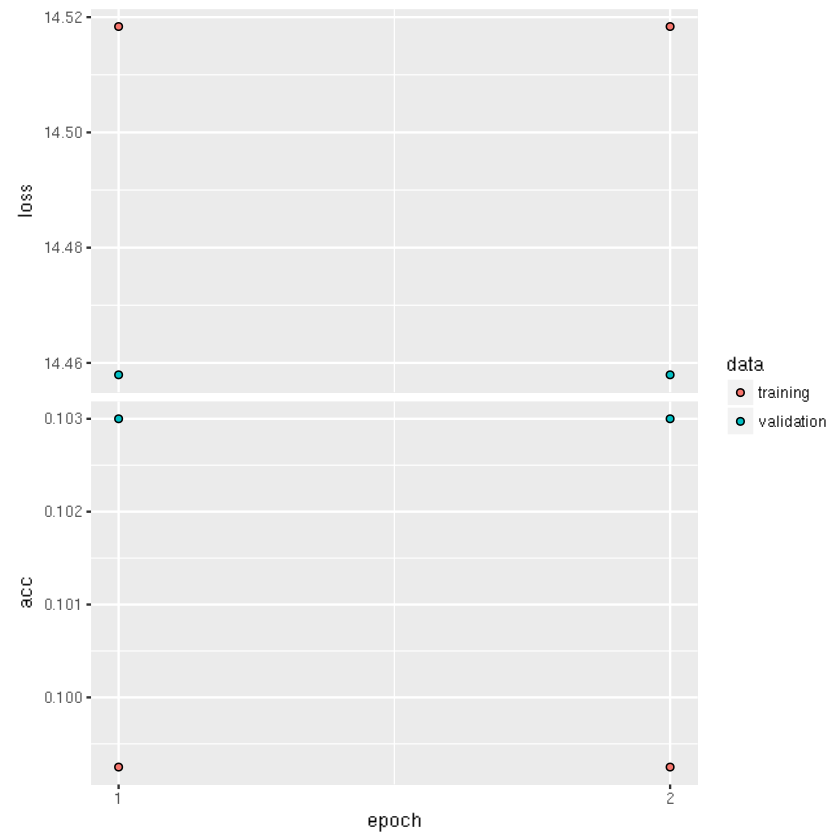

In [89]:
plot(history)

In [90]:
# evaluate the performance
model_conv %>% evaluate(x_test, y_test)

$loss
[1] 14.50629

$acc
[1] 0.1

# 4. The importance of regularization 

# 5. Transfer Learning: working with pre-trained models

In real-world applications, the amount of available, labeled train data is often times limited. As the performance of deep learning models is highly dependent on vast amounts of data, methods to overcome this problem were and currently are developed. One of such techniques is __transfer learnig__.

The basic idea behind transfer learning is training a model on a rich, labeled dataset for a task that is related to the task of interest and then fine-tune this model on the small amount of labeled data form the initial task of interest. 

One example for a rich, labeled and public data set is [ImageNet](http://www.image-net.org/) provided by Stanford University, which contains XXX million images for YYY classes. 

In this chapter, we 

1. use a pretrained model to classifiy the object in a new, arbitrary image
2. fine-tune a pre-trained model on a new task

## 5.1. Use a pretrained net for classification 

We use the a pretrained VGG16 architecture to classify a new, arbitrary image. We use the picture of a peaceful cow and a set of dishes (licensed for free, commercial use by [pexels.com](https://www.pexels.com/search/cow/)). The VGG16 was trained on coloured RGB images with the dimension (xdim = 224, ydim = 224, channels = 3), thus we made sure, the images have the same dimensions. 

### 5.1.1 Cow detection 

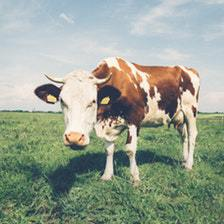

  format width height colorspace matte filesize density
1   JPEG   224    224       sRGB FALSE    20166   72x72

[1]   1 224 224   3

In [3]:
# get the image
# magick package
cow = image_read(path = './data/cow.jpg')
cow
# get the data
cow_data = as.integer(image_data(cow))
# add 4th dimension such that the resulting array has dim
# (batch size, xdim, ydim, channel size)
cow_data = array(cow_data, c(1, 224, 224, 3))
dim(cow_data)

In [ ]:
# get the pretrained model from the keras library
# load the weights from the folder of this Repository
# we already downloaded the weights to this location for you
model_pretrained = application_resnet50(weights = 
    './models/resnet50_weights_tf_dim_ordering_tf_kernels.h5')

In [38]:
# The ResNet50 architecture, that we now deploy as a classifier for the cow and the dished, is a 
# lot more advanced than the simple CNN that we build in chapter 2. Let us take a look at the architecture:
summary(model_pretrained)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_5 (InputLayer)      (None, 224, 224,  0                                   
________________________________________________________________________________
conv1 (Conv2D)            (None, 112, 112,  9472     input_5[0][0]              
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 112, 112,  256      conv1[0][0]                
________________________________________________________________________________
activation_50 (Activation (None, 112, 112,  0        bn_conv1[0][0]             
________________________________________________________________________________
max_pooling2d_2 (MaxPooli (None, 55, 55, 64 0        activation_50[0][0]        
________________________________________________________________________________
res2a_branch2a (Conv2D)   (N

In [93]:
# run the model to make the prediction 
prediction = model_pretrained %>% predict(cow_data)

In [94]:
# check the predicted classes with the top 5 highest scores
imagenet_decode_predictions(preds = prediction, top = 5)[1]

class_name,class_description,score
n02403003,ox,0.9488235712
n03868242,oxcart,0.0484120362
n03967562,plow,0.0008429451
n02408429,water_buffalo,0.0004129720
n02389026,sorrel,0.0002694723


### 5.1.1. Dishes detection 

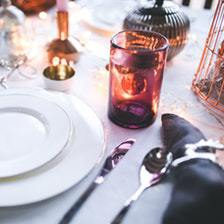

  format width height colorspace matte filesize density
1   JPEG   224    224       sRGB FALSE    18408   72x72

In [95]:
# get the dishes image
dishes = image_read(path = './data/dishes.jpg')
dishes_data = as.integer(image_data(dishes))
dishes_data = array(dishes_data, c(1, 224, 224, 3))
dishes

In [96]:
# make prediction and show top5 results
prediction = model_pretrained %>% predict(dishes_data)
imagenet_decode_predictions(preds = prediction, top = 5)[1]

class_name,class_description,score
n03666591,lighter,0.21436484
n03063689,coffeepot,0.11708578
n04557648,water_bottle,0.05618625
n03759954,microphone,0.04109137
n03544143,hourglass,0.03379996


## 5.2. Fine-tune a pretrained net on a new task

We gathered a data set of 150 images of chicago buildings and 250 ancient egyptian buildings from [Wikicommons](https://commons.wikimedia.org/wiki/Hauptseite) provided by [researcher Zhe Xu](https://sites.google.com/site/zhexuutssjtu/projects/arch). 

As the type of the building has a major impact on its insurance premium, we want to predict the architecture from images of the buildings. 

Unfortunately, our data set is too small to train a deep convolutional neural network for this task end-to-end. Thus, we use the previous pretrained ResNet50 which was trained on ImageNet and fine tune it on our specific task.

In [1]:
# example image of ancient egyptian building
egyptian = image_read(path = './data/arch_data/train/egypt/egypt1.jpg')
egyptian

ERROR: Error in image_read(path = "./data/arch_data/train/egypt/egypt1.jpg"): konnte Funktion "image_read" nicht finden


In [2]:
# example image of building from chicago
chicago = image_read(path = './data/arch_data/train/chicago/chicago1.jpg')
chicago

ERROR: Error in image_read(path = "./data/arch_data/train/chicago/chicago1.jpg"): konnte Funktion "image_read" nicht finden


In [3]:
# get the train data file paths
train_paths_chicago = paste0('./data/arch_data/train/chicago/', list.files('./data/arch_data/train/chicago/'))
train_paths_egypt = paste0('./data/arch_data/train/egypt/', list.files('./data/arch_data/train/egypt/'))
all_train_paths = c(train_paths_chicago, train_paths_egypt)
amount_train_data = length(train_paths_chicago) + length(train_paths_egypt)
# how many train images do we have?
amount_train_data

[1] 325

In [21]:
# instantiate X_train array with rgb images 
X_train = array(0, c(amount_train_data, 3, 224, 224))
for(i in 1:amount_train_data){
    # read, and resize image
    img = magick::image_resize(image = magick::image_read(path = all_train_paths[i]), geometry = "224x224!")
    X_train[i, , , ] = as.integer(magick::image_data(img))
}
# permute axis to (#images, yaxis, xaxis, #channels)
X_train = aperm(X_train, c(1, 3, 4, 2))

y_train = array(c(rep(0, length(train_paths_chicago)), rep(1, length(train_paths_egypt))), c(325, 1))

In [22]:
# get the test data file paths
test_paths_chicago = paste0('./data/arch_data/validation/chicago/', list.files('./data/arch_data/validation/chicago/'))
test_paths_egypt = paste0('./data/arch_data/validation/egypt/', list.files('./data/arch_data/validation/egypt/'))
all_test_paths = c(test_paths_chicago, test_paths_egypt)
amount_test_data = length(test_paths_chicago) + length(test_paths_egypt)
# how many test images do we have?
amount_test_data

[1] 73

In [23]:
# instantiate X_train array with rgb images 
X_test = array(0, c(amount_test_data, 3, 224, 224))
for(i in 1:amount_test_data){
    # read, and resize image
    img = magick::image_resize(image = magick::image_read(path = all_test_paths[i]), geometry = "224x224!")
    X_test[i, , , ] = as.integer(magick::image_data(img))
}
# permute axis to (#images, yaxis, xaxis, #channels)
X_test = aperm(X_test, c(1, 3, 4, 2))

y_test = array(c(rep(0, length(test_paths_chicago)), rep(1, length(test_paths_egypt))), c(amount_test_data, 1))

In [24]:
# what is the label distribution?
# 125 chicago images and 200 egypt images for training 
table(y_train)
# 19 chicago and 54 egypt images for testing
table(y_test)

y_train
  0   1 
125 200 

y_test
 0  1 
19 54 

#### Build and train the model

In [113]:
# we use the pretrained Resnet and 'cut off its head' 
# and add two convolutional layers 
# which we will fine-tune
# important: specify the input shape first
# the weights are already a part of this repo, more details on additional, pretrained
# architectures can be found in the sources at the end of the notebook
input_tensor <- layer_input(shape = c(224, 224, 3))
base_model <- application_resnet50(input_tensor = input_tensor,
    weights = './models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    include_top = FALSE)

In [114]:
summary(base_model)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_3 (InputLayer)      (None, 224, 224,  0                                   
________________________________________________________________________________
conv1 (Conv2D)            (None, 112, 112,  9472     input_3[0][0]              
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 112, 112,  256      conv1[0][0]                
________________________________________________________________________________
activation_99 (Activation (None, 112, 112,  0        bn_conv1[0][0]             
________________________________________________________________________________
max_pooling2d_3 (MaxPooli (None, 55, 55, 64 0        activation_99[0][0]        
________________________________________________________________________________
res2a_branch2a (Conv2D)   (N

In [115]:
# add our custom layers
ext_model <- base_model$output %>% 
    layer_flatten() %>% 
    layer_dense(units = 128, activation = 'relu') %>% 
    layer_dense(units = 1, activation = 'sigmoid')

# this is the model we will train
model <- keras_model(inputs = base_model$input, outputs = ext_model)

In [116]:
# check the layers in this huge model
layers <- model$layers
for (i in 1:length(layers))
  cat(i, layers[[i]]$name, "\n")

1 input_3 
2 conv1 
3 bn_conv1 
4 activation_99 
5 max_pooling2d_3 
6 res2a_branch2a 
7 bn2a_branch2a 
8 activation_100 
9 res2a_branch2b 
10 bn2a_branch2b 
11 activation_101 
12 res2a_branch2c 
13 res2a_branch1 
14 bn2a_branch2c 
15 bn2a_branch1 
16 add_33 
17 activation_102 
18 res2b_branch2a 
19 bn2b_branch2a 
20 activation_103 
21 res2b_branch2b 
22 bn2b_branch2b 
23 activation_104 
24 res2b_branch2c 
25 bn2b_branch2c 
26 add_34 
27 activation_105 
28 res2c_branch2a 
29 bn2c_branch2a 
30 activation_106 
31 res2c_branch2b 
32 bn2c_branch2b 
33 activation_107 
34 res2c_branch2c 
35 bn2c_branch2c 
36 add_35 
37 activation_108 
38 res3a_branch2a 
39 bn3a_branch2a 
40 activation_109 
41 res3a_branch2b 
42 bn3a_branch2b 
43 activation_110 
44 res3a_branch2c 
45 res3a_branch1 
46 bn3a_branch2c 
47 bn3a_branch1 
48 add_36 
49 activation_111 
50 res3b_branch2a 
51 bn3b_branch2a 
52 activation_112 
53 res3b_branch2b 
54 bn3b_branch2b 
55 activation_113 
56 res3b_branch2c 
57 bn3b_branch2c 
5

In [117]:
# train only the top layers 
# freeze all layers from the ResNet50
freeze_weights(model, from = 1, to = 174)
# binary task -> binary cross entropy loss
model %>% compile(optimizer = 'sgd', 
                loss = 'binary_crossentropy', 
                metrics = c('accuracy'))

In [118]:
# check the architecture of this massive model
# special attention: 'only' a small fraction of the 24Mio parameters will be fine-tuned
summary(model)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_3 (InputLayer)      (None, 224, 224,  0                                   
________________________________________________________________________________
conv1 (Conv2D)            (None, 112, 112,  9472     input_3[0][0]              
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 112, 112,  256      conv1[0][0]                
________________________________________________________________________________
activation_99 (Activation (None, 112, 112,  0        bn_conv1[0][0]             
________________________________________________________________________________
max_pooling2d_3 (MaxPooli (None, 55, 55, 64 0        activation_99[0][0]        
________________________________________________________________________________
res2a_branch2a (Conv2D)   (N

In [119]:
history = model %>% fit(
    x = X_train, 
    y = y_train, 
    epochs = 1, 
    batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1
)

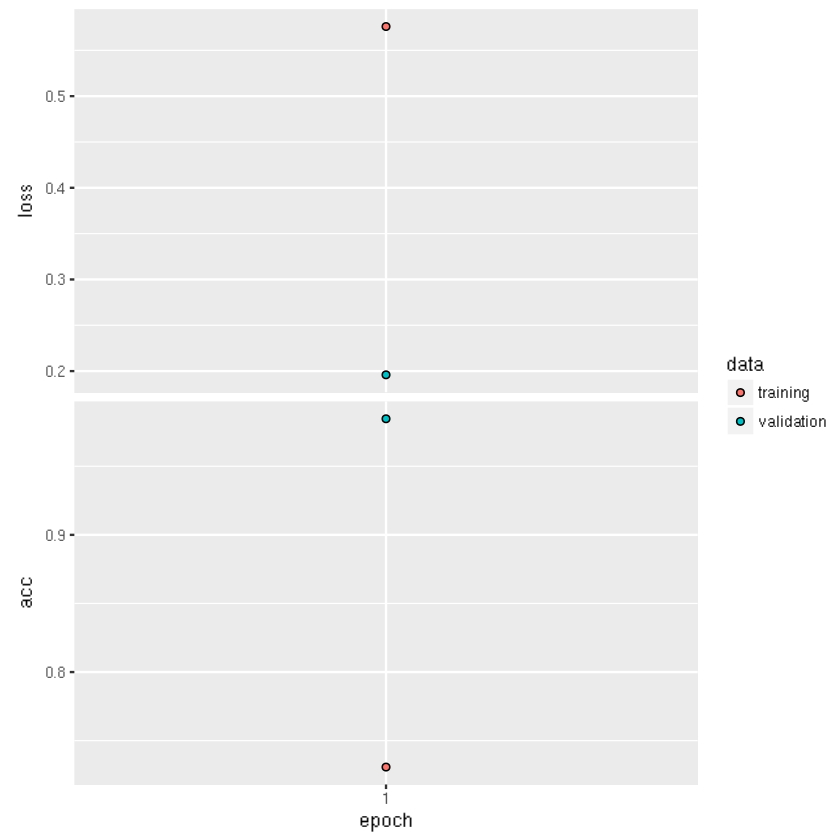

In [120]:
plot(history)

#### Evaluate performance

In [121]:
# evaluate the performance on the test data
model %>% evaluate(X_test, y_test)

$loss
[1] 0.3187348

$acc
[1] 0.9041096

In [122]:
# make predictions on all our test data
preds = model %>% predict(X_test)

In [123]:
# set threshold to 0.5 to yield hard predictions
# what would be a better way to yield a reasonable threshold?
yhat = ifelse(preds > 0.5, 1, 0)
pred_frame = as.data.frame(cbind(preds, yhat, y_test))
colnames(pred_frame) = c('prob', 'yhat', 'y_test')
head(pred_frame)

prob,yhat,y_test
0.6291046,1,0
0.3504156,0,0
0.4788982,0,0
0.5714399,1,0
0.8136709,1,0
0.4212023,0,0


In [124]:
# simple accuracy 
# important note: not taking into account the unbalancedness of the test data
acc = length(which(pred_frame$yhat == pred_frame$y_test)) / nrow(pred_frame)
acc

[1] 0.9041096

In [125]:
# confusion matrix
# instantiate empty confusion matrix as data frame
conf_frame = as.data.frame(matrix(0, nrow = 2, ncol = 2))
# transform factors to integers
# loop over all possible true labels
for(label in 0:1){
    # filter for current label
    dat = pred_frame %>% 
        dplyr::filter(y_test == label)
    # loop over all predictable labels
    for(pred in 0:1){
        # count for each predictable label, how often it was predicted for which lass
        conf_frame[pred + 1, label + 1] = length(which(dat$yhat == pred)) 
    }
}
# rename the columns with the actual label values
colnames(conf_frame) = c('chicago', 'egypt')
rownames(conf_frame) = c('chicago', 'egypt')

In [126]:
# inspect the confusion matrix
# rows represent the predicted values and columns represent the true values
# a perfect confusion matrix contains only non-zero values on the diagonal 
# how can we interpret those results?
# what would be next steps for troubleshooting?
conf_frame

,chicago,egypt
chicago,12,0
egypt,7,54


#### Check the missclassified images

For troubleshooting, it is usual to check especially those images that were missclassified by the model.

In [127]:
# indices of the missclassified chicago buildings
miss_chicago = which(pred_frame$yhat != pred_frame$y_test & pred_frame$y_test == 0)
miss_chicago

[1]  1  4  5  7 10 14 19

In [128]:
# indices of the missclassified egypt buildings
miss_egypt = which(pred_frame$yhat != pred_frame$y_test & pred_frame$y_test == 1)
miss_egypt

integer(0)

,prob,yhat,y_test
1,0.6291046,1,0
4,0.5714399,1,0
5,0.8136709,1,0
7,0.7151427,1,0
10,0.5548339,1,0
14,0.7243022,1,0
19,0.5467451,1,0


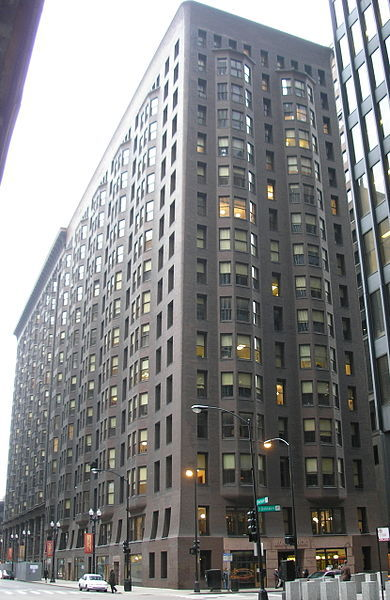

  format width height colorspace matte filesize density
1   JPEG   390    600       sRGB FALSE    62687   72x72

In [129]:
# probability scores for the missclassified samples to be part of class egyptian 
# p(y = 1|X)
# it is interesting to see, that despite of sample 10 it was a close decision for the net
# maybe, the color structure of image 10 is similar to an ancient egyptian building?
pred_frame[miss_chicago, ]
# show the third missclassified chicago image
miss_chicago_image = image_read(path = paste0('./data/arch_data/train/chicago/chicago', miss_chicago[3], '.jpg'))
miss_chicago_image

In [130]:
# probability scores for the missclassified samples to be part of class egyptian 
# p(y = 1|X)
# it is interesting to see, that it was a very close decision for the net for all three pyramids
pred_frame[miss_egypt, ]
# show the first missclassified egypt image
miss_egypt_image = image_read(path = paste0('./data/arch_data/train/egypt/egypt', miss_egypt[1], '.jpg'))
miss_egypt_image

prob,yhat,y_test


ERROR: Error in magick_image_readpath(path, density, depth, strip): Magick: UnableToOpenBlob `./data/arch_data/train/egypt/egyptNA.jpg': No such file or directory @ error/blob.c/OpenBlob/2761


# 6. Data Generator for huge data sets

One problem in deep learning with massive amounts of data is, that the whole data set might not fit in the GPU memory. One option to overcome this limitation is the usage of a __data generator__. This is basically an object, that sequentially loads one batch of data (usually 32-64 data points) into the model during the batch-wise training process. 

In addition to that, one can use __data augmentation__ techniques within the data gernerator. This means, that each image is getting shifted/ rotated/ cropped  in such a way, that the meaning of the image does not change (a flipped t-shirt is still a t-shirt which also holds for ancient egypt pyramids). This way, the dataset is augmented artificially which can help increase the model performance. Also, this is done on the fly during training. 

Keras utilities make it straightforward to implement such a data generator which we will do in the following. We continue working on the architecture-detection problem. 

In [134]:
# define a data generator that handles the preprocessing/ augmentation of each 
# single image
# here, we only do vertical flipping
# check the docu for the full set of possible augmentation techniques
data_generator_train = image_data_generator(
    horizontal_flip = FALSE,
    vertical_flip = TRUE)

# we do not apply any augmentation on the validation data
data_generator_validation = image_data_generator(
    horizontal_flip = FALSE,
    vertical_flip = FALSE)

The function `flow_images_from_directory()` creates a data generator solely based on the image data being stored on a given path. Therefore, the data should follow such a folder structure:
* data  
    * train
        * classname 0
            *  classname0_1.jpg
            *  classname0_2.jpg
            *  ...
        * classname 1
        * ...
    * validation 
        * classname 0
        * classname 1
        * ...
    
Given this folder structure, the function will determine the amount of classes and images by itself. For an example, check the folder `./data/arch_data/` in this repository.

In [135]:
train_generator = flow_images_from_directory(
    directory = './data/arch_data/train/', 
    generator = data_generator_train, 
    target_size = c(224, 224), 
    classes = c('chicago', 'egypt'),
    color_mode = 'rgb',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = TRUE
)
validation_generator = flow_images_from_directory(
    directory = './data/arch_data/validation/', 
    generator = data_generator_validation, 
    target_size = c(224, 224),
    classes = c('chicago', 'egypt'),
    color_mode = 'rgb',
    batch_size = 32, 
    class_mode = 'categorical',
    shuffle = FALSE
)

In [136]:
# we use the pretrained Resnet and 'cut off its head' 
# and add two convolutional layers, 
# which we will fine-tune
input_tensor <- layer_input(shape = c(224, 224, 3))
base_model <- application_resnet50(input_tensor = input_tensor,
    weights = './models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    include_top = FALSE)

In [142]:
# add our custom layers
ext_model <- base_model$output %>% 
    layer_flatten() %>% 
    layer_dense(units = 128, activation = 'relu') %>% 
    layer_dense(units = 2, activation = 'softmax')

# this is the model we will train
model_gen <- keras_model(inputs = base_model$input, outputs = ext_model)

In [143]:
# train only the top layers 
# freeze all layers from the ResNet50
freeze_weights(model_gen, from = 1, to = 174)
model_gen %>% compile(optimizer = 'sgd', 
                loss = 'categorical_crossentropy', 
                metrics = c('accuracy'))

In [144]:
# check the architecture of this massive model
# special attention: 'only' a fraction of the 24Mio parameters will be fine-tuned
summary(model_gen)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_6 (InputLayer)      (None, 224, 224,  0                                   
________________________________________________________________________________
conv1 (Conv2D)            (None, 112, 112,  9472     input_6[0][0]              
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 112, 112,  256      conv1[0][0]                
________________________________________________________________________________
activation_246 (Activatio (None, 112, 112,  0        bn_conv1[0][0]             
________________________________________________________________________________
max_pooling2d_6 (MaxPooli (None, 55, 55, 64 0        activation_246[0][0]       
________________________________________________________________________________
res2a_branch2a (Conv2D)   (N

In [147]:
# train the model on the new data for a few epochs
# using the above defined generators
history = model_gen %>% fit_generator(generator = train_generator,
                        # amount of batches to be fed 
                        steps_per_epoch = ceiling(length(all_train_paths) / 32) * 2, 
                        validation_data = validation_generator,
                        # amount of batches to be fed 
                        validation_steps = ceiling(length(all_train_paths) / 32),
                        epochs = 2, 
                        verbose = 1)

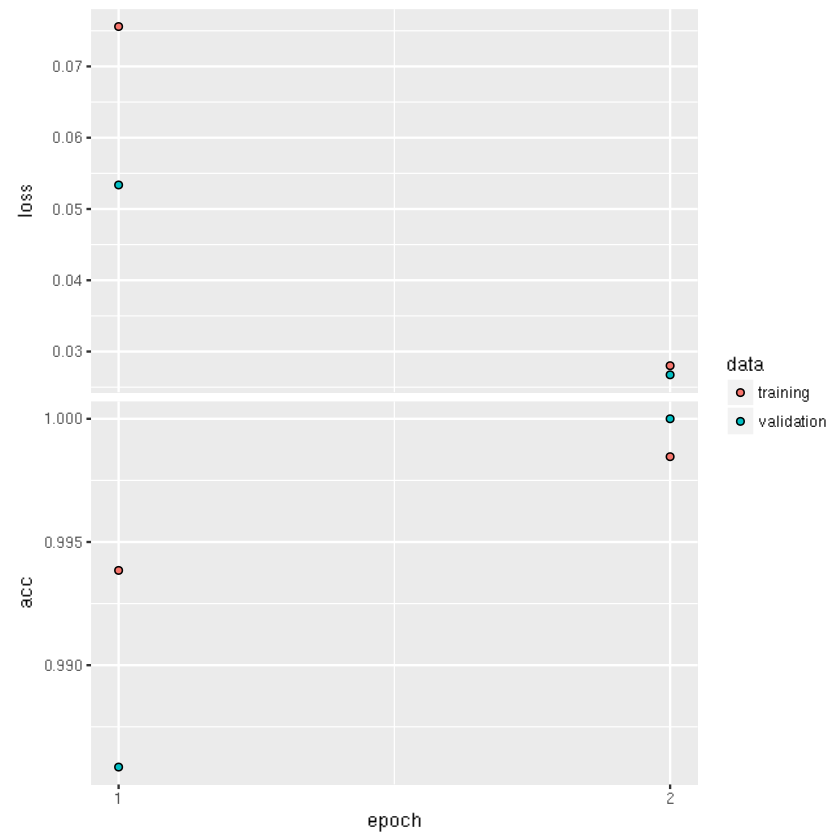

In [148]:
plot(history)

In [149]:
# make predictions on the validation data
preds = predict_generator(object = model_gen, 
                          steps = 3,
                          generator = validation_generator, 
                          verbose = 1)

In [150]:
# evaluate the results using the simple (and not optimal)
# accuracy measure provided by the evaluat_generator() function 
# for the validation generator
eval_result = evaluate_generator(object = model_gen, 
                   generator = validation_generator, 
                   steps = 3,
                   workers = 1)
print(eval_result)

$loss
[1] 0.0258033

$acc
[1] 1



## Sources

* [CRAN vignette for keras](https://cran.r-project.org/web/packages/keras/vignettes/getting_started.html)
* [Image manipulation in R with magick](https://cran.r-project.org/web/packages/magick/vignettes/intro.html)
* [Examples for keras in R](https://keras.rstudio.com/articles/examples/index.html)
* [Transfer learning with keras in R](https://cran.rstudio.com/web/packages/keras/vignettes/applications.html)
* [kaggle kernel on vgg16](https://www.kaggle.com/dkoops/keras-r-vgg16-base)
* [folder structure for the train generator](https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)